In [1]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

from sklearn import metrics
from sklearn.metrics import r2_score
from methods import *
import math
import pickle
from sklearn.model_selection import KFold

In [3]:
#build model
def create_nn(
    learning_rate,
    num_dense_layers,
    neurons2,
    activation,
    neurons,
    drop_out1,
    drop_out2,
    _factor,
    _patience
    ):

    model = Sequential()
    model.add(Dense(neurons,input_dim=2333, activation=activation))
    model.add(Dropout(drop_out1))

    for i in range(num_dense_layers):
        model.add(Dense(neurons2,activation=activation,
                    ))
        model.add(Dropout(drop_out2))
    model.add(Dense(2))


    opt = Adam(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='mse', metrics=["mean_squared_error"])


    return model

In [27]:
#Hyperparameter Space
dim_learning_rate = Real(
    low=1e-6, high=1e-2, prior='log-uniform', name='learning_rate',
)

dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')

neurons2 = Integer(low=64, high=2048, name='neurons2')
batch_size=Integer(low=64, high=256, name='batch_size')
neurons=Integer(low=128, high=2048, name='neurons')
drop_out1=Real(low=0.00001, high=0.4, prior='uniform', name='drop_out1',)
drop_out2=Real(low=0.00001, high=0.4, prior='uniform', name='drop_out2',)
_factor=Real(low=0.00001, high=0.99999, prior='uniform', name='_factor',)
_patience=Integer(low=1, high=10, name='_patience')
dim_activation = Categorical(
    categories=['relu','sigmoid'], name='activation',
)


In [28]:
param_grid = [dim_learning_rate,
              dim_num_dense_layers,
              neurons2,
              dim_activation,
              batch_size,
              neurons,
              drop_out1,
              drop_out2,
             _factor,
              _patience
              ]

In [29]:
file='x_train,x_test,y_train,y_test.pkl'

In [30]:
x,y=unpickling(file) ; 

In [31]:
y_lon=pd.DataFrame(y['east_GT'])
y_lat=pd.DataFrame(y['north_GT'])

In [32]:
def mean_from_scores(scores):
    sum_var=0
    count_var=0
    for i in scores:
        sum_var+=i
        count_var+=1
    return sum_var/count_var               

In [33]:
initial_learning_rate = 0.01


In [34]:
x_scaler, x_scaled1 = Scaling(x)
lon_scaler, lon_scaled=Scaling(y_lon)
lat_scaler, lat_scaled=Scaling(y_lat)
y_scaled1=np.append(lon_scaled,lat_scaled,axis = 1)




In [35]:
x_scaler, x_scaled = Scaling(x)
lon_scaler, lon_scaled=Scaling(y_lon)
lat_scaler, lat_scaled=Scaling(y_lat)
y_scaled=np.append(lon_scaled,lat_scaled,axis = 1)




In [36]:
x_scaled, x_final_test, y_scaled, y_final_test = train_test_split(x_scaled1, y_scaled1, test_size=0.1) #, random_state=

In [37]:
cv = KFold(n_splits=4, random_state=1, shuffle=True)


In [38]:
x_traing=[]
x_testg=[]
y_testg=[]
y_traing=[]


for train_index, test_index in cv.split(x_scaled):
    x_train, x_test = x_scaled[train_index], x_scaled[test_index]
    y_train, y_test = y_scaled[train_index], y_scaled[test_index]
    x_traing.append(x_train)
    x_testg.append(x_test)
    y_testg.append(y_test)
    y_traing.append(y_train)
    
    

In [39]:
#number of epochs
epochs = 1
#save path
path_best_model = 'SkoptGP.h8_100'
#trying to mimimze loss function, therefore starting at infinity and any number would be less and would be counted as best loss
best_loss = 1000000000000000000000000000000000000000000000000000

In [40]:
predictionscores=[]

#use names is a skopt funciton for referring to param hyperspace
@use_named_args(param_grid)
def objective(
        learning_rate,
        num_dense_layers,
        neurons2,
        activation,
        batch_size,
        neurons,
        drop_out1,
        drop_out2,
        _factor,
        _patience,


):
#printing paramater choice
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('neurons2:', neurons2)
    print('activation:', activation)
    print('batch_size', batch_size)
    print('neurons', neurons)
    print('drop_out1', drop_out1)
    print('drop_out2', drop_out2)
    print('_factor', _factor)
    print('_patience', _patience)
    print()

    model = create_nn(learning_rate=learning_rate,
                       num_dense_layers=num_dense_layers,
                       neurons2=neurons2,
                       activation=activation,
                       neurons=neurons,
                       drop_out1=drop_out1,
                       drop_out2=drop_out2,
                       _factor=_factor,
                       _patience=_patience)
#learning rate reduction is used as call back and can be optimize as well
    learning_rate_reduction = ReduceLROnPlateau(monitor='loss',
                                                patience=_patience,
                                                verbose=1,
                                                factor=_factor,
                                                min_lr=0.00001)


    scores=[]
   
    for index, var in enumerate(x_traing):
        scores2=[]


        for train_index, test_index in cv.split(x_scaled):
            x_train, x_test = x_scaled[train_index], x_scaled[test_index]
            y_train, y_test = y_scaled[train_index], y_scaled[test_index]
        
            history=model.fit(x=x_train,y=y_train,epochs =1 , validation_data=(x_test,y_test), batch_size=int(batch_size),callbacks=[learning_rate_reduction])
            #can be changed to val loss?
            scores2.append(history.history['loss'][-1]+history.history['val_loss'][-1])

            



        scores.append(mean_from_scores(scores2))

        print(f" small loss : {mean_from_scores(scores2)}")


    predictions = model.predict(x_test)
    
    #modeling final results
    pred_lon=inv_scaler(lon_scaler, predictions[:,0])
    pred_lat=inv_scaler(lat_scaler, predictions[:,1])

    lat_test=inv_scaler(lat_scaler,y_test[:,1].reshape(-1,1))
    lon_test=inv_scaler(lon_scaler,y_test[:,0].reshape(-1,1))
    
    results, difs_df_sorted=calculate_diff(lon_test,pred_lon,lat_test,pred_lat)
    mid=difs_df_sorted.median()
    predictionscores.append(mid)

    loss = mean_from_scores(scores)
    print(f" loss: {loss}")
    global best_loss

    if loss < best_loss:

        model.save(path_best_model)

        best_loss = loss

    del model

    return loss

In [41]:
gp_ = gp_minimize(
    objective,
    param_grid,
    acq_func='EI',
    n_calls=12)
#    random_state=0,)

learning rate: 5.0e-03
num_dense_layers: 3
neurons2: 339
activation: sigmoid
batch_size 238
neurons 844
drop_out1 0.044202385655554476
drop_out2 0.013503433775382602
_factor 0.00017142812851460748
_patience 8

19/19 [==============================] - 1s 69ms/step - loss: 0.0513 - mean_squared_error: 0.0513 - val_loss: 0.0463 - val_mean_squared_error: 0.0463 - lr: 0.0050
 small loss : 0.4582423707470298
19/19 [==============================] - 1s 62ms/step - loss: 0.0508 - mean_squared_error: 0.0508 - val_loss: 0.0478 - val_mean_squared_error: 0.0478 - lr: 0.0050
 small loss : 0.0967348013073206
19/19 [==============================] - 1s 59ms/step - loss: 0.0500 - mean_squared_error: 0.0500 - val_loss: 0.0463 - val_mean_squared_error: 0.0463 - lr: 0.0050
 small loss : 0.09646079502999783
19/19 [==============================] - 1s 65ms/step - loss: 0.0492 - mean_squared_error: 0.0492 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - lr: 0.0050
 small loss : 0.09758010786026716
45/4

23/23 [==============================] - 1s 42ms/step - loss: 0.0791 - mean_squared_error: 0.0791 - val_loss: 0.0657 - val_mean_squared_error: 0.0657 - lr: 7.8829e-06
 small loss : 0.15656990185379982
23/23 [==============================] - 1s 39ms/step - loss: 0.0744 - mean_squared_error: 0.0744 - val_loss: 0.0593 - val_mean_squared_error: 0.0593 - lr: 7.8829e-06
 small loss : 0.13607137836515903
45/45 [==============================] - 1s 7ms/step
 loss: 0.2407630728557706
learning rate: 4.0e-05
num_dense_layers: 2
neurons2: 1548
activation: sigmoid
batch_size 229
neurons 1639
drop_out1 0.31411057980096335
drop_out2 0.2183979129701819
_factor 0.8604811545799624
_patience 6

19/19 [==============================] - 3s 161ms/step - loss: 0.1879 - mean_squared_error: 0.1879 - val_loss: 0.0463 - val_mean_squared_error: 0.0463 - lr: 4.0146e-05
 small loss : 0.4514461290091276
19/19 [==============================] - 3s 164ms/step - loss: 0.1696 - mean_squared_error: 0.1696 - val_loss: 0.

 small loss : 0.029098204569891095
45/45 [==============================] - 1s 13ms/step
 loss: 0.04305307992035523
learning rate: 3.7e-05
num_dense_layers: 2
neurons2: 307
activation: relu
batch_size 160
neurons 1919
drop_out1 0.3174200784204257
drop_out2 0.2818885912549125
_factor 0.2645707498565617
_patience 5

27/27 [==============================] - 1s 39ms/step - loss: 0.0449 - mean_squared_error: 0.0449 - val_loss: 0.0285 - val_mean_squared_error: 0.0285 - lr: 3.7065e-05
 small loss : 0.11335436254739761
27/27 [==============================] - 1s 39ms/step - loss: 0.0306 - mean_squared_error: 0.0306 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - lr: 3.7065e-05
 small loss : 0.0570378084667027
27/27 [==============================] - 1s 38ms/step - loss: 0.0249 - mean_squared_error: 0.0249 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - lr: 3.7065e-05
 small loss : 0.044280034489929676
27/27 [==============================] - 1s 39ms/step - loss: 0.0219 - mean_squar

In [42]:
"Best score=%.4f" % gp_.fun

'Best score=0.0260'

In [43]:
for position, name in enumerate(gp_.space.dimension_names):
    print(f"{name}   {gp_.x[position]}")

learning_rate   0.00020496248524529636
num_dense_layers   3
neurons2   606
activation   relu
batch_size   124
neurons   507
drop_out1   0.09248247608539732
drop_out2   0.032324040793013535
_factor   0.40961229556534967
_patience   7


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

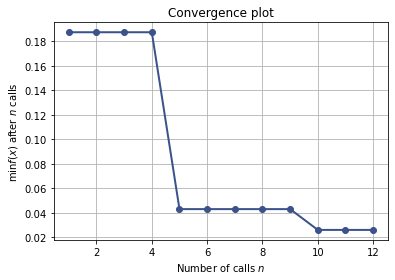

In [44]:
plot_convergence(gp_)

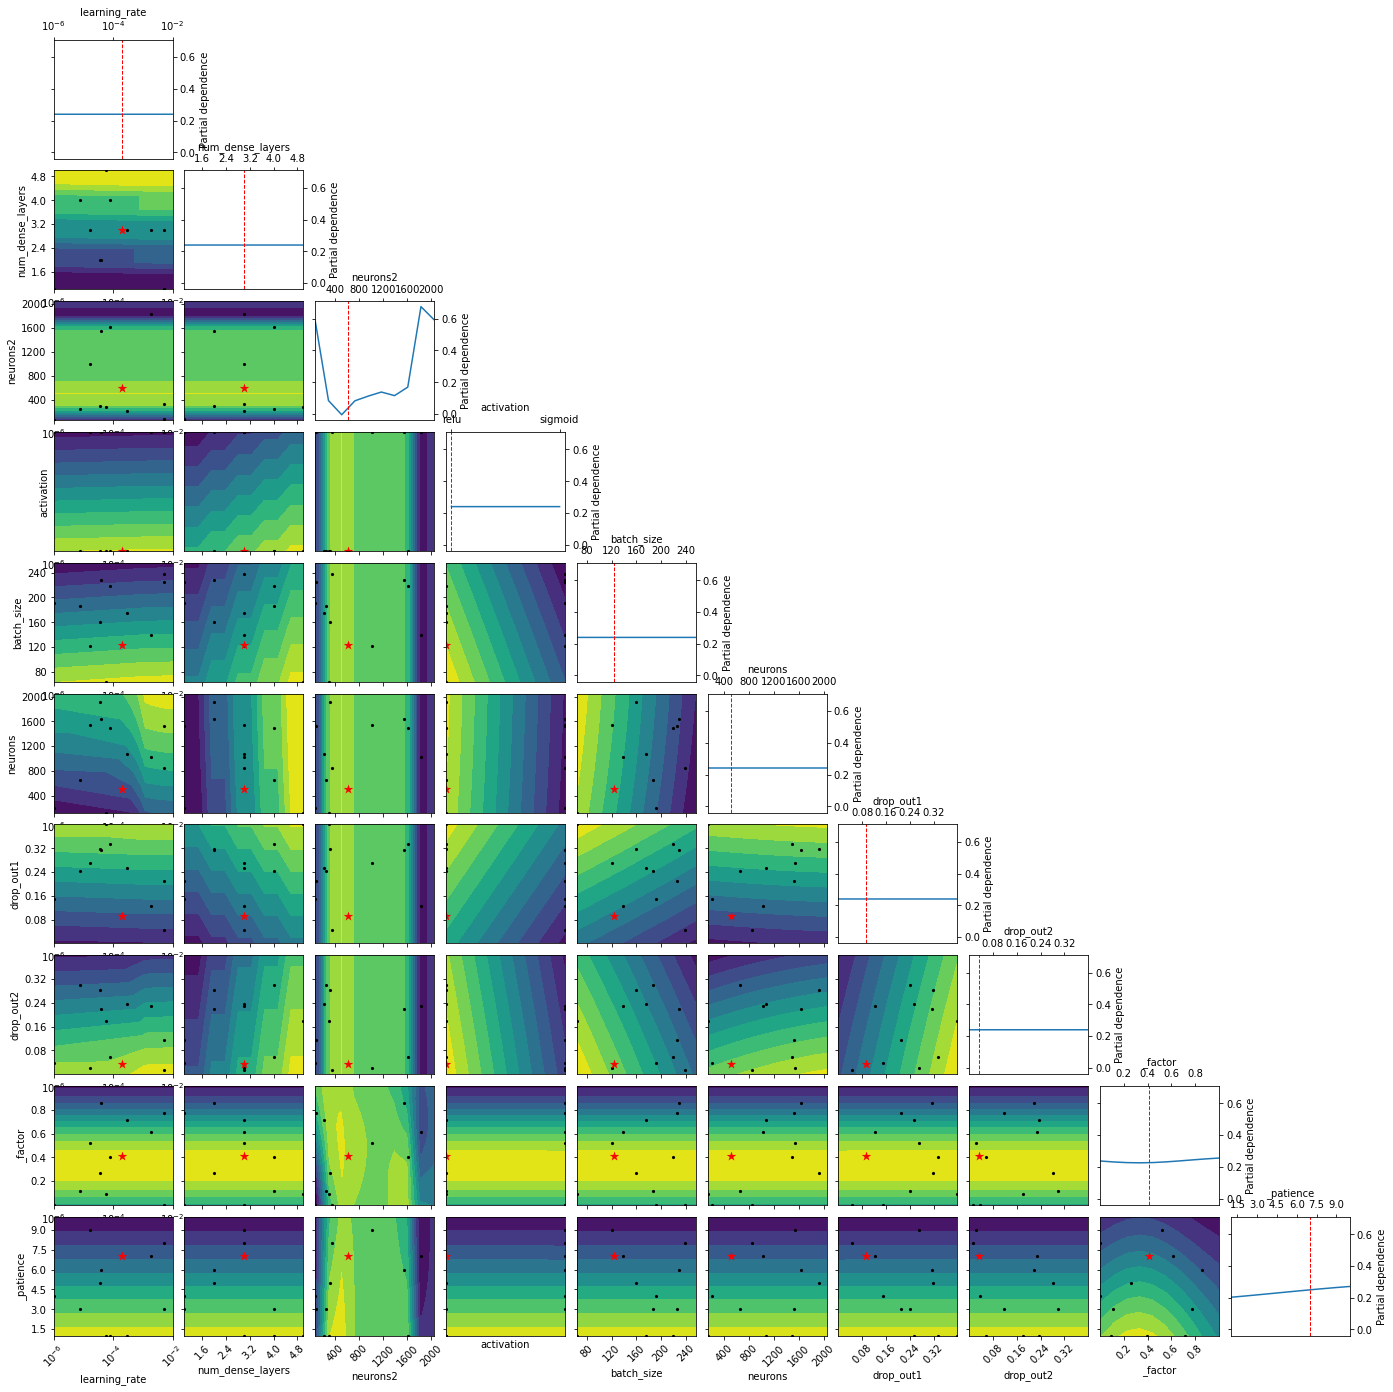

In [45]:
plot_objective(result=gp_,n_points=10)
plt.show()

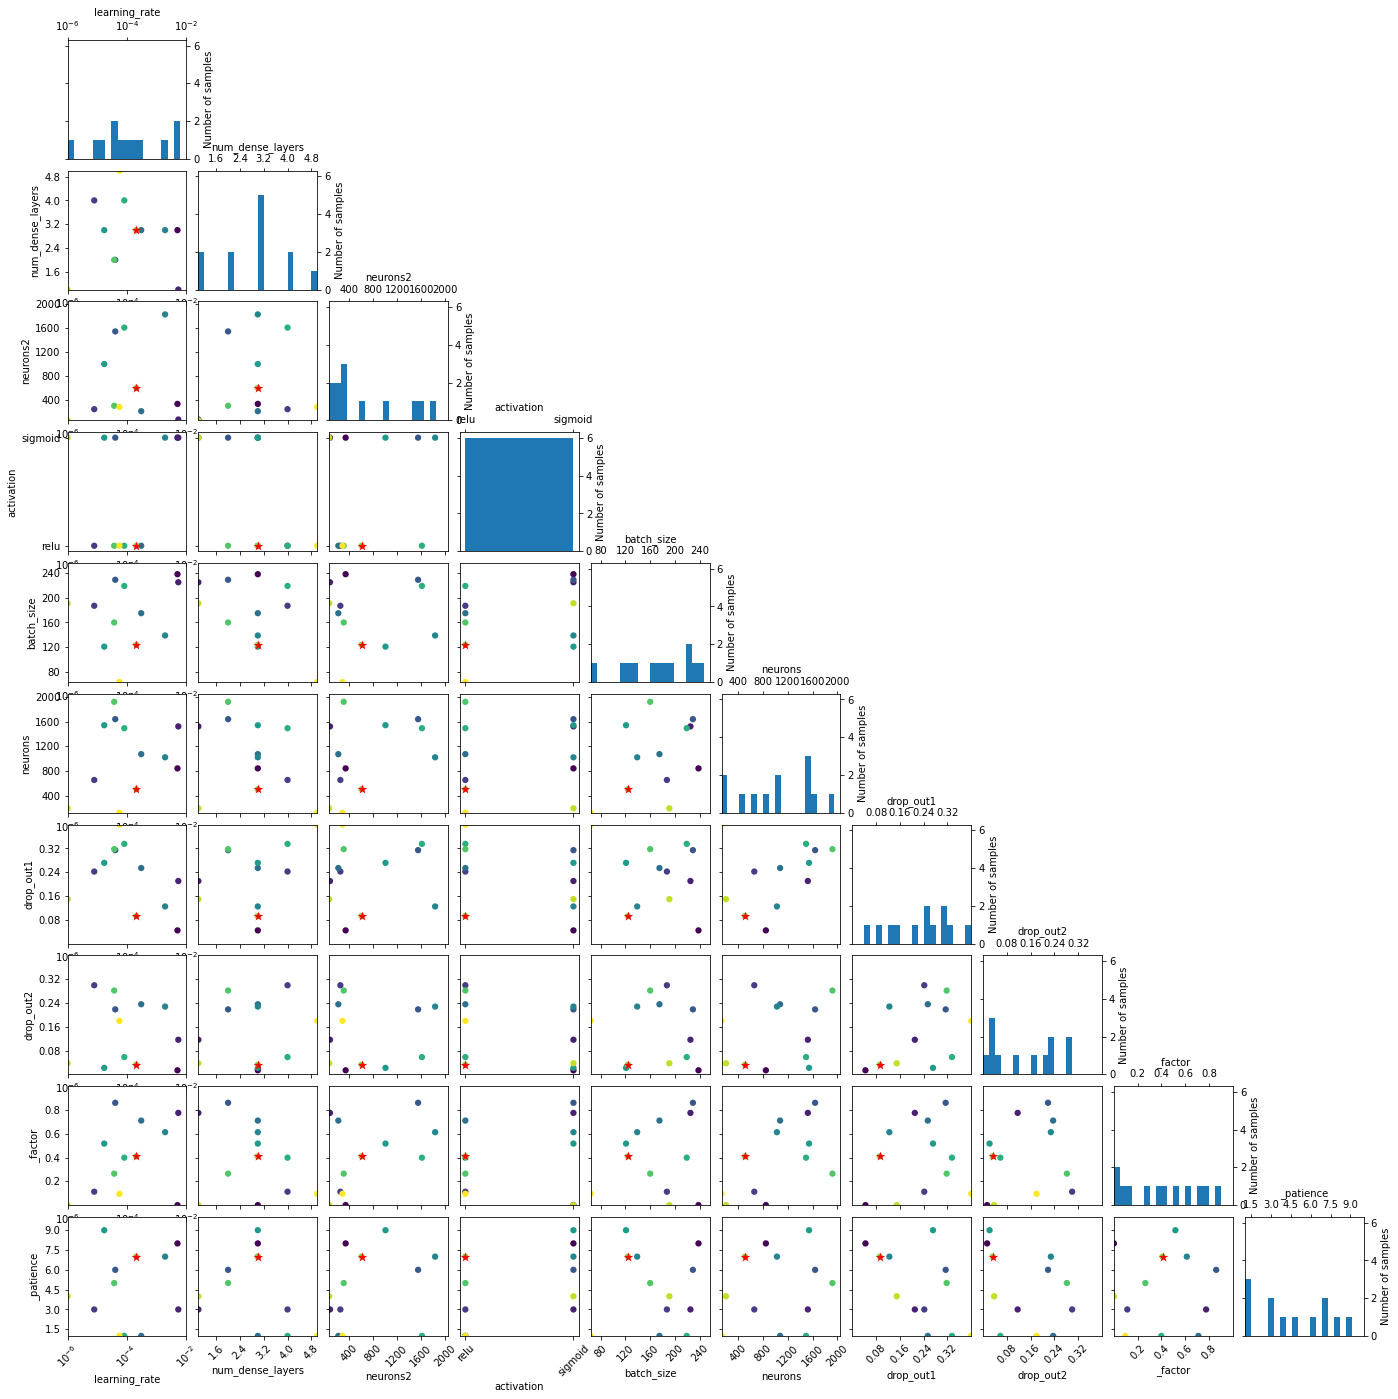

In [46]:
plot_evaluations(result=gp_)
plt.show()

In [47]:
model = load_model(path_best_model)
predictions = model.predict(x_test)


45/45 [==============================] - 0s 5ms/step


In [48]:
#modeling final results
pred_lon=inv_scaler(lon_scaler, predictions[:,0])
pred_lat=inv_scaler(lat_scaler, predictions[:,1])

lat_test=inv_scaler(lat_scaler,y_test[:,1].reshape(-1,1))
lon_test=inv_scaler(lon_scaler,y_test[:,0].reshape(-1,1))


Text(0.5, 1.0, 'Combined')

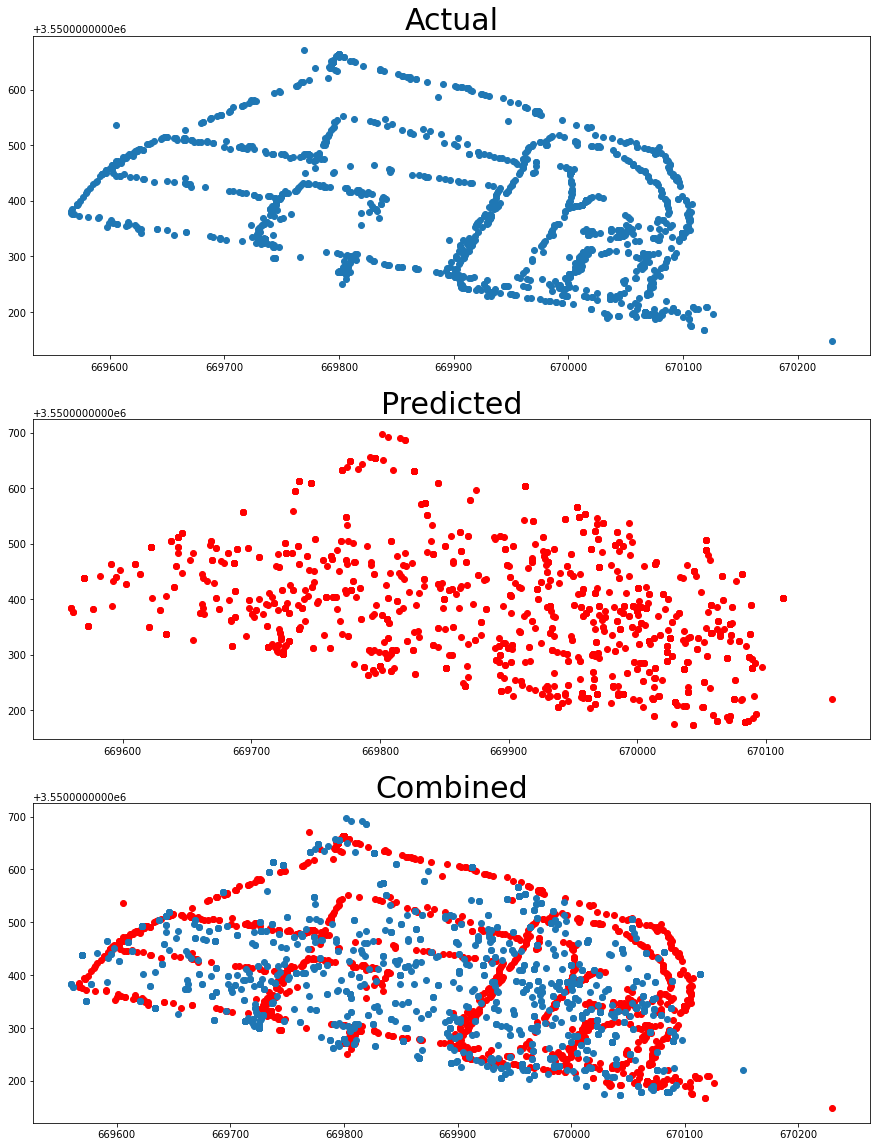

In [49]:
fig, ax = plt.subplots(3)

ax[0].scatter(lon_test,lat_test)
fig.set_size_inches(15,20)
ax[0].set_title("Actual", size= 30)
ax[1].scatter(pred_lon,pred_lat, color="red")
ax[1].set_title("Predicted", size= 30)
ax[2].scatter(lon_test,lat_test, color="red")
ax[2].scatter(pred_lon,pred_lat)
ax[2].set_title("Combined", size= 30)


In [50]:
results, difs_df_sorted=calculate_diff(lon_test,pred_lon,lat_test,pred_lat)


In [51]:
results

,lon_test,pred_lon,lat_test,pred_lat,diff
0,176.846,162.2315,241.853,176.058,67.398558
1,306.233,288.8565,381.704,366.558,23.050902
2,172.860,199.3565,259.737,256.308,26.717458
3,539.047,546.6690,214.924,254.308,40.114765
4,205.591,169.6690,336.531,348.058,37.726142
...,...,...,...,...,...
1426,508.574,499.1690,337.638,294.058,44.583298
1427,476.331,442.6065,198.450,175.808,40.620217
1428,535.493,546.6690,252.767,254.308,11.281740
1429,471.040,429.2315,364.818,354.308,43.109289


In [52]:
difs_df_sorted.describe()

,diff
count,1431.000000
mean,59.628399
std,58.467676
min,2.079123
25%,22.026799
50%,38.821451
75%,72.623553
max,388.686858


In [53]:
print(difs_df_sorted.quantile(q=0.8))
print(difs_df_sorted.quantile(q=0.85))
print(difs_df_sorted.quantile(q=0.9))
print(difs_df_sorted.median())


diff    87.529802
Name: 0.8, dtype: float64
diff    109.465004
Name: 0.85, dtype: float64
diff    145.072502
Name: 0.9, dtype: float64
diff    38.821451
dtype: float64


In [54]:
predictionscores

[diff    172.885164
 dtype: float64,
 diff    133.657272
 dtype: float64,
 diff    198.184629
 dtype: float64,
 diff    175.212273
 dtype: float64,
 diff    77.094289
 dtype: float64,
 diff    176.837022
 dtype: float64,
 diff    169.635652
 dtype: float64,
 diff    97.187882
 dtype: float64,
 diff    76.817678
 dtype: float64,
 diff    38.821451
 dtype: float64,
 diff    580.966698
 dtype: float64,
 diff    124.571306
 dtype: float64]

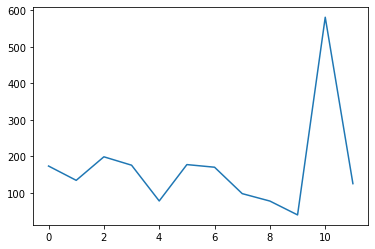

In [55]:
plt.plot(predictionscores)